# Valuation of Convertible Bonds with Monte Carlo Simulation

By Biao Wang, Zhongcheng Liang

## Introduction
Convertible bonds are complex financial derivatives. According to the terms of convertible bonds, holders can earn corresponding interest during the holding period and receive the principal and a certain amount of compensatory interest on the bond's maturity date. They can also choose to convert the bonds into the underlying stocks in advance as stipulated by the terms or sell the bonds back to the issuer. On the other hand, the issuer can redeem the bonds or adjust the conversion price downward under certain conditions as specified in the terms.

For investors, convertible bonds offer the opportunity to benefit from stock price increases and, at the same time, allow them to avoid the risks of stock price declines in the form of bonds. Their return characteristics are "having a floor and a ceiling". The "floor" refers to the interest income stipulated as a bond, which is determined by its pure bond value. The "ceiling" results from the restrictions of the call provision. When the call provision is triggered, the issuing company can issue a call notice to force investors to convert their bonds into stocks.

These terms give rise to a complex game-playing process between investors and the issuing company when they exercise their respective options. Convertible bonds possess the characteristics of both corporate bonds and stock options and are also exposed to various risks. Therefore, accurately pricing them is a highly challenging task. 

In our project, we use Monte Carlo simulation to model the price movements of the underlying stocks of convertible bonds. Then, based on the terms of the convertible bonds, we generate the terminal values corresponding to each simulated path. Finally, we discount these values to obtain the value of the convertible bonds, thereby achieving the pricing of convertible bonds.

The terms of convertible bonds and the resulting game - playing between investors and the issuing companies are extremely complex and difficult to fully simulate. Therefore, we have made some corresponding simplifications here. Considering more details, such as the downward adjustment of the conversion price and the decision of whether to convert the bonds into stocks, requires more sophisticated techniques. We can incorporate these into our model in the future. 

## Data
Our data are mainly downloaded from **CSMAR**, with only conversion prices from **iFind**, then simply processed and saved as parquet files. We use parquet files because they can be easily read and saved with smaller sizes.


In [1]:
# load data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from dask_expr import read_parquet

# basic infos of bonds
bonds_infos = pd.read_parquet('data/bonds_info_merged.parquet')
# data of bonds' trading
bonds_trading_data = pd.read_parquet('data/bonds_trading.parquet')
# yield curves of treasuries
yield_curves = pd.read_parquet('data/yield_curve_csmar.parquet')
# data of stock prices
stock_prices_all = pd.read_parquet('data/stock_prices.parquet')
# data of conversion prices and price changes
conversion_prices = pd.read_parquet('data/conversion_prices_csmar.parquet')

### Basic information of bonds
The data contains basic information of 1012 bonds, including code, name, listing date, etc. 

In [2]:
bonds_infos.shape

(1012, 10)

In [3]:
bonds_infos.head()

,bond_code,list_date,symbol,stock_code,maturity_date,value_date,coupon,conversion_start_date,conversion_end_date,redemption_price
0,100001,1998-09-02,南化转债,600301,2003-08-02,1998-08-03,1.0,2000-07-12,2003-08-02,NaN
1,100009,2000-03-16,机场转债,600009,2005-02-24,2000-02-25,0.8,2000-08-25,2005-02-24,100.8
2,100016,2003-03-18,民生转债,600016,2008-02-27,2003-02-27,1.5,2003-08-27,2008-02-27,102.0
3,100087,2002-08-28,水运转债,600087,2007-08-12,2002-08-13,0.9,2003-08-13,2007-08-13,100.9
4,100096,2003-09-25,云化转债,600096,2006-09-09,2003-09-10,1.6,2004-03-10,2006-09-09,NaN


### Data of trading records
The data contains 632745 daily records of convertible bonds' trading, including open price, close price, lowest price, and highest price, starting from 1998-09-02. 

In [4]:
bonds_trading_data.shape

(632745, 7)

In [5]:
bonds_trading_data.head()

,bond_code,date,open,close,high,low,conversion_price
0,100001,1998-09-02,232.00,229.00,250.00,200.18,4.56
1,100001,1998-09-03,210.00,190.50,222.90,189.80,4.56
2,100001,1998-09-04,185.22,210.01,213.99,185.22,4.56
3,100001,1998-09-07,202.01,217.80,224.90,200.50,4.56
4,100001,1998-09-08,218.30,216.66,221.49,213.50,4.56


In [6]:
bonds_trading_data.sort_values(by='date', ascending=True).head(5)

,bond_code,date,open,close,high,low,conversion_price
0,100001,1998-09-02,232.00,229.00,250.00,200.18,4.56
1,100001,1998-09-03,210.00,190.50,222.90,189.80,4.56
2,100001,1998-09-04,185.22,210.01,213.99,185.22,4.56
3,100001,1998-09-07,202.01,217.80,224.90,200.50,4.56
4,100001,1998-09-08,218.30,216.66,221.49,213.50,4.56


### Yield curves
The data contains the yields to maturity of treasury bonds from 2002-01-04 to 2025-01-13 with different maturities. 

In [7]:
yield_curves.sort_values(by='trading_date').head(5)

,0S,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y,40Y,50Y
trading_date,,,,,,,,,,,,,,,,,,,,,
2002-01-04,0.025132,0.025192,0.025252,0.025312,0.025492,0.025671,0.025850,0.026563,0.027271,0.027975,...,0.029368,0.030057,0.030741,0.031421,0.032096,0.035400,0.038586,0.044600,NaN,NaN
2002-01-07,0.025315,0.025373,0.025431,0.025489,0.025663,0.025836,0.026009,0.026697,0.027380,0.028057,...,0.029394,0.030055,0.030710,0.031359,0.032003,0.035141,0.038140,0.043724,NaN,NaN
2002-01-08,0.016574,0.016796,0.017016,0.017235,0.017885,0.018526,0.019156,0.021578,0.023842,0.025946,...,0.029676,0.031302,0.032769,0.034076,0.035225,0.038578,0.037951,0.024752,NaN,NaN
2002-01-09,0.016275,0.016512,0.016748,0.016983,0.017680,0.018366,0.019040,0.021627,0.024036,0.026266,...,0.030190,0.031884,0.033400,0.034737,0.035896,0.039010,0.037660,0.021569,NaN,NaN
2002-01-10,0.016239,0.016475,0.016709,0.016942,0.017635,0.018316,0.018987,0.021559,0.023954,0.026173,...,0.030082,0.031772,0.033285,0.034623,0.035784,0.038943,0.037693,0.021966,NaN,NaN


In [8]:
yield_curves.sort_values(by='trading_date').tail(5)

,0S,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y,40Y,50Y
trading_date,,,,,,,,,,,,,,,,,,,,,
2025-01-13,0.010486,0.012785,0.013994,0.014076,0.014076,0.012341,0.012342,0.012515,0.013042,NaN,...,NaN,0.015711,NaN,NaN,0.016685,0.018372,0.020083,0.019159,0.019721,0.019880
2025-01-14,0.013487,0.013975,0.013975,0.013977,0.013854,0.012118,0.012143,0.012209,0.012911,NaN,...,NaN,0.015501,NaN,NaN,0.016543,0.018159,0.019796,0.018740,0.019792,0.019964
2025-01-15,0.013677,0.013975,0.013975,0.013975,0.012595,0.011987,0.012043,0.012135,0.012580,NaN,...,NaN,0.015529,NaN,NaN,0.016424,0.018096,0.019666,0.018697,0.019682,0.019834
2025-01-16,0.014673,0.014932,0.014474,0.014474,0.013066,0.012428,0.012199,0.012366,0.012806,NaN,...,NaN,0.015526,NaN,NaN,0.016489,0.018179,0.019769,0.018769,0.019724,0.019843
2025-01-17,0.015171,0.015381,0.014380,0.014226,0.012991,0.012527,0.012597,0.012708,0.012807,NaN,...,NaN,0.015789,NaN,NaN,0.016690,0.018382,0.019975,0.019278,0.019699,0.019769


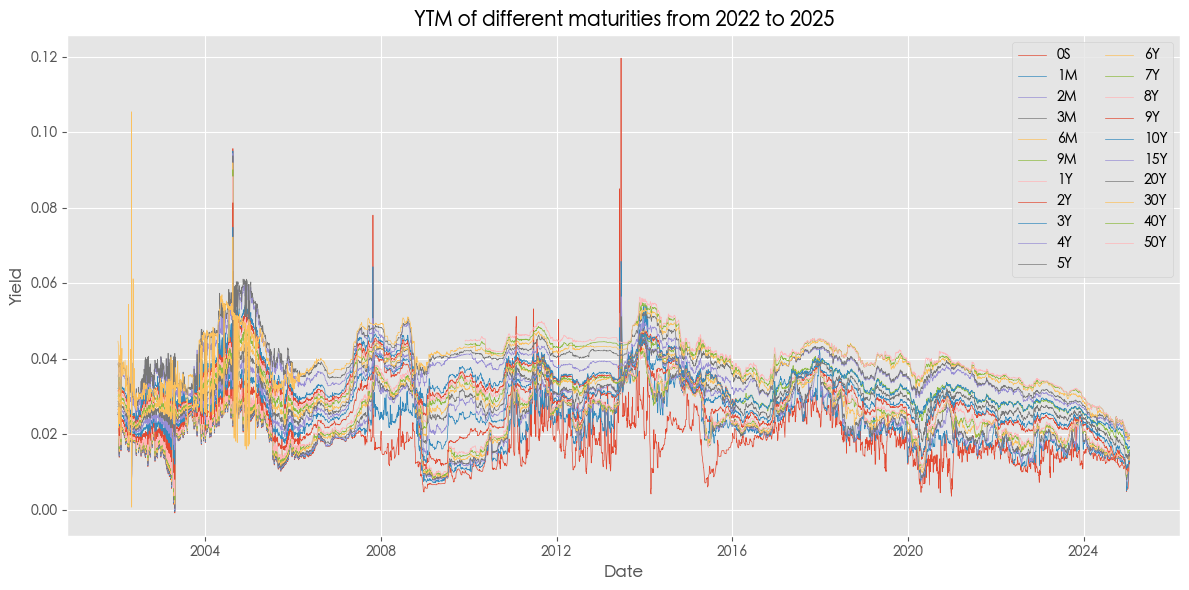

In [37]:
# interest rate curves
fig1, ax1 = plt.subplots(figsize=(12, 6))

x = pd.to_datetime(yield_curves.index)
for i in yield_curves.columns[:]:
    ax1.plot(x, yield_curves[i], label=i, linewidth=0.5)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator(4))
ax1.set_xlabel('Date')
ax1.set_ylabel('Yield')
ax1.legend(ncol=2)
plt.title('YTM of different maturities from 2022 to 2025')
plt.tight_layout()

plt.show()

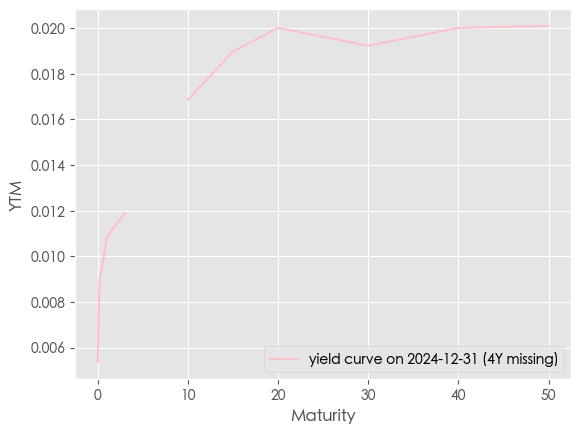

In [40]:
# Example: the yield curve on 2024-12-31
yield_curve = yield_curves.loc['2024-12-31']
maturities = [0, 1/12, 1/6, 1/4, 1/2, 3/4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50] 
fig, ax = plt.subplots()
ax.plot(maturities, yield_curve, color = 'pink', label='yield curve on 2024-12-31 (4Y missing)')
ax.set_xlabel('Maturity')
ax.set_ylabel('YTM')
ax.legend()
plt.show()

### Data of stocks' price
The data contain 5871714 price records of all stocks from 2020-01-20 to 2025-01-17, including open price, close price, lowest price, and highest price.    
We use these data to calculate the volatility and simulate the paths.

In [11]:
stock_prices_all.shape

(5871714, 6)

In [12]:
stock_prices_all.head()

,stock_code,date,open,high,low,close
0,000001,2020-01-20,16.43,16.61,16.35,16.45
1,000001,2020-01-21,16.34,16.34,15.93,16.00
2,000001,2020-01-22,15.92,16.16,15.71,16.09
3,000001,2020-01-23,15.92,15.92,15.39,15.54
4,000001,2020-02-03,13.99,14.70,13.99,13.99


In [13]:
stock_prices_all.tail()

,stock_code,date,open,high,low,close
5871709,920128,2025-01-13,28.90,28.90,27.70,27.76
5871710,920128,2025-01-14,28.16,29.87,28.01,29.85
5871711,920128,2025-01-15,29.20,30.15,28.98,29.01
5871712,920128,2025-01-16,29.40,30.28,28.99,29.08
5871713,920128,2025-01-17,29.00,29.80,28.79,29.12


### Conversion price
The data contains the conversion prices of convertible bonds and their changes. (4746 records)  
We use the data to determine the conversion price when pricing a bond on a certain date.

In [14]:
conversion_prices.shape

(4746, 10)

In [15]:
conversion_prices.head(5)

,bond_code,exchange_code,symbol,declare_date,effective_date,restart_date,conversion_price,conversion_price_before,change_reason,change_note
0,100001,1,南化转债,1998-08-03,1998-08-03,2000-07-12,4.56,NaN,发行,None
1,100009,1,机场转债,2000-02-25,2000-02-25,2000-08-25,10.00,NaN,发行,None
2,100009,1,机场转债,2003-12-22,2003-12-26,2003-12-26,7.69,10.00,送股,None
3,100016,1,民生转债,2003-02-27,2003-02-27,2003-08-27,10.11,NaN,发行,None
4,100016,1,民生转债,2003-04-08,2003-04-14,2003-04-14,7.73,10.11,"派现,送股,转增股本",None


In [16]:
# Example: 立讯转债, the conversion price changes 32 times
conversion_prices[conversion_prices['symbol'] == '立讯转债']

,bond_code,exchange_code,symbol,declare_date,effective_date,restart_date,conversion_price,conversion_price_before,change_reason,change_note
4652,128136,2,立讯转债,2020-10-30,2020-11-03,2021-05-10,58.62,NaN,发行,None
4653,128136,2,立讯转债,2020-12-14,2020-12-14,2020-12-14,58.60,58.62,股权激励,"公司于2020年6月22日召开了第四届董事会第十九次会议和第四届监事会第十九次会议,审议通过..."
4654,128136,2,立讯转债,2020-12-30,2020-12-30,2020-12-30,58.48,58.60,股权激励,"公司于2020年6月22日召开了第四届董事会第十九次会议和第四届监事会第十九次会议,审议通过..."
4655,128136,2,立讯转债,2021-01-13,2021-01-13,2021-01-13,58.44,58.48,股权激励,"公司于2020年6月22日召开了第四届董事会第十九次会议和第四届监事会第十九次会议,审议通过..."
4656,128136,2,立讯转债,2021-02-24,2021-02-24,2021-02-24,58.38,58.44,股权激励,"公司于2020年6月22日召开了第四届董事会第十九次会议和第四届监事会第十九次会议,审议通过..."
4657,128136,2,立讯转债,2021-03-11,2021-03-11,2021-03-11,58.36,58.38,股权激励,"公司于2020年6月22日召开了第四届董事会第十九次会议和第四届监事会第十九次会议,审议通过..."
4658,128136,2,立讯转债,2021-06-30,2021-07-08,2021-07-08,58.25,58.36,派现,"公司2020年年度权益分派方案为:以公司现有总股本7,035,428,828股为基数,向全体..."
4659,128136,2,立讯转债,2021-07-22,2021-07-22,2021-07-22,58.20,58.25,股权激励,根据立讯精密工业股份有限公司(以下简称“公司”)《立讯精密工业股份有限公司公开发行可转换公司...
4660,128136,2,立讯转债,2021-09-04,2021-09-06,2021-09-06,58.18,58.20,股权激励,公司2018年股票期权激励计划第二个行权期的行权期限为2020年12月22日至2021年9月...
4661,128136,2,立讯转债,2021-11-10,2021-11-10,2021-11-10,58.16,58.18,股权激励,公司2018年股票期权激励计划第二个行权期的行权期限为2020年12月22日至2021年9月...


## Valuation
We use Monte Carlo method to pricing convertible bonds. specifically, the method include following steps:
1. Simulate Stock Price Paths: $S_{t+\Delta t } = S_t \cdot e^{(r - \frac{1}{2} \sigma^2)\Delta t + \sigma \sqrt{\Delta t} Z}$, where $Z$ follows standard normal distribution. 
2. Calculate the Terminal Value of the Convertible Bond for Each Path: At the end of each simulated path, we calculate the value of the convertible bond according to the conversion, call, and put provisions of the convertible bond.
3. Discount the Terminal Values: We discount the terminal value of each path back to the present using the risk-free interest rate. 
4. Calculate the Average to Obtain the Convertible Bond Price: We calculate the average of all discounted terminal values, and this average is the estimated price of the convertible bond.


### Some preparation work

In [34]:
# import packages
import numpy as np
import talib as ta  # a package for technical analysis
import math
import random
import pandas_market_calendars as mcal  # a package used to get trading calendar
import sys
from tqdm import tqdm  # progress bar
import pyarrow as pa 
import pyarrow.parquet as pq  # read and save data in parquet files
import os

In [18]:
# define some functions used in monte-carlo pricing

# find risk-free rate from yield curves
def risk_free_rate(date_pricing, date_maturity, yield_curves):
    yield_curve = yield_curves[yield_curves.index == date_pricing].iloc[-1]  # get the yield curve on the day of pricing
    if type(date_pricing) is str:
        date_pricing = pd.Timestamp(date_pricing)
    if type(date_maturity) is str:
        date_maturity = pd.Timestamp(date_maturity)
    remaining_days = (date_maturity - date_pricing).days  # Remaining Time to Maturity
    # get risk-free rate of the same period
    if remaining_days <= 30:
        risk_free = yield_curve['1M']
    elif remaining_days <= 60:
        risk_free = yield_curve['2M']
    elif remaining_days <= 90:
        risk_free = yield_curve['3M']
    elif remaining_days <= 180:
        risk_free = yield_curve['6M']
    elif remaining_days <= 270:
        risk_free = yield_curve['9M']
    elif remaining_days <= 365:
        risk_free = yield_curve['1Y']
    else:
        year = math.ceil(remaining_days / 365)
        risk_free = yield_curve[str(year) + 'Y']
        if str(risk_free) == 'nan':
            risk_free = (yield_curve[str(year - 1) + 'Y'] + yield_curve[str(year + 1) + 'Y']) / 2
    return remaining_days, risk_free

# calculate stock's spot price and spot volatility
def stock_param(stock_code, stock_prices_all, date_pricing):
    stock_prices = stock_prices_all[stock_prices_all['stock_code'] == stock_code]
    start = str(int(date_pricing.split('-')[0]) - 1) + '-' + date_pricing.split('-')[1] + '-' + date_pricing.split('-')[2]
    # calculate the volatility in tha past year
    stock_prices_1y = stock_prices[(stock_prices['date'] <= date_pricing) & (stock_prices['date'] > start)]
    stock_prices_1y = stock_prices_1y.reset_index(drop=True)
    spot_price = stock_prices_1y['close'].iloc[-1]  # spot price of the date of pricing
    stock_prices_1y['return'] = stock_prices_1y['close'] / stock_prices_1y['close'].shift(1) - 1
    stock_prices_1y['volatility'] = pd.Series(dtype='float64')
    stock_prices_1y['volatility'] = np.sqrt(252) * stock_prices_1y['return'].rolling(window=120).std()  # rolling with window=120
    stock_prices_1y['volatility_ema'] = ta.EMA(stock_prices_1y['volatility'], 60)  # exponential moving average
    spot_vol = stock_prices_1y['volatility_ema'].iloc[-1]  # spot volatility of the date of pricing
    return spot_price, spot_vol

# extract conversion price of the bond
def strike_price(date_pricing, conversion_prices, bond_code):
    conversion_price = conversion_prices[conversion_prices.bond_code == bond_code]
    strike_price = 0
    conversion_price.loc[:, 'effective_date'] = pd.to_datetime(conversion_price['effective_date'])
    if type(date_pricing) is str:
        date_pricing = pd.Timestamp(date_pricing)
    # get the strike price corresponding to the date of pricing
    if date_pricing >= conversion_price['effective_date'].iloc[-1]:
        strike_price = conversion_price['conversion_price'].iloc[-1]
    elif date_pricing >= conversion_price['effective_date'].iloc[0]:
        for i in range(len(conversion_price) - 1):
            if date_pricing >= conversion_price['effective_date'].iloc[i] and date_pricing < conversion_price['effective_date'].iloc[i + 1]:
                strike_price = conversion_price['conversion_price'].iloc[i]
    else: 
        strike_price = 0
        print(bond_code + ':计算时间在初次转股价格发布日之前')
        sys.exit(0)
    
    return strike_price  

# calculate the number of trading days, 
exchange_calendar = mcal.get_calendar('SSE')  # SSE, SZSE, and BSE share a same trading calendar
def days_to_conversion(conversion_date, pricing_date):
    if conversion_date > pricing_date: 
        schedule = exchange_calendar.schedule(start_date=pricing_date, end_date=conversion_date)
        trading_days = exchange_calendar.valid_days(start_date=schedule.index[0], end_date=schedule.index[-1])
        n = len(trading_days) - 1
    else: 
        schedule = exchange_calendar.schedule(start_date=conversion_date, end_date=pricing_date)
        trading_days = exchange_calendar.valid_days(start_date=schedule.index[0], end_date=schedule.index[-1])
        n = 1- len(trading_days) 
    return n

### Simulation
define a function of simulation: name of bond, date, number of steps, number of simulations

In [19]:
def mc_simulation(bond_name, bonds_infos:pd.DataFrame, yield_curves:pd.DataFrame, stock_prices_all:pd.DataFrame, date, step, simulations):
    # get basic information of the bond
    bond_infos = bonds_infos[bonds_infos['symbol'] == bond_name]
    stock_code = bond_infos['stock_code'].iloc[0]
    maturity_date = bond_infos['maturity_date'].iloc[0]
    
    # parameters of simulation
    remaining_days, r= risk_free_rate(date, maturity_date, yield_curves)  # r = rf
    S, v = stock_param(stock_code, stock_prices_all, date)
    AT = 1 / 252
    
    # simulate the stock prices
    stockvalue = S * np.exp(np.cumsum((r - 0.5 * v ** 2) * AT +
                            v * math.sqrt(AT) *
                            np.random.standard_normal((step, simulations)), axis=0))
    stockvalue[0] = S
    stockvalue = stockvalue.T
    return stockvalue

In [20]:
# Example: 弘亚转债，starting from 2024-12-31, 500 steps, 1000 simulations
stockvalue = mc_simulation('弘亚转债', bonds_infos, yield_curves, stock_prices_all, '2024-12-31', 500, 1000)

In [21]:
stockvalue[:5, :]

array([[16.83      , 16.78605548, 17.07629701, ...,  5.64231161,
         5.83331897,  5.84259207],
       [16.83      , 16.92869722, 17.02765603, ..., 12.6399974 ,
        12.43047399, 11.85800046],
       [16.83      , 16.6085403 , 16.21530742, ..., 20.1326184 ,
        20.66163935, 20.79261558],
       [16.83      , 17.20277043, 16.6934887 , ..., 35.17946679,
        34.55250687, 33.79001038],
       [16.83      , 15.98144757, 15.57521448, ..., 36.75088167,
        36.74785059, 36.9812744 ]])

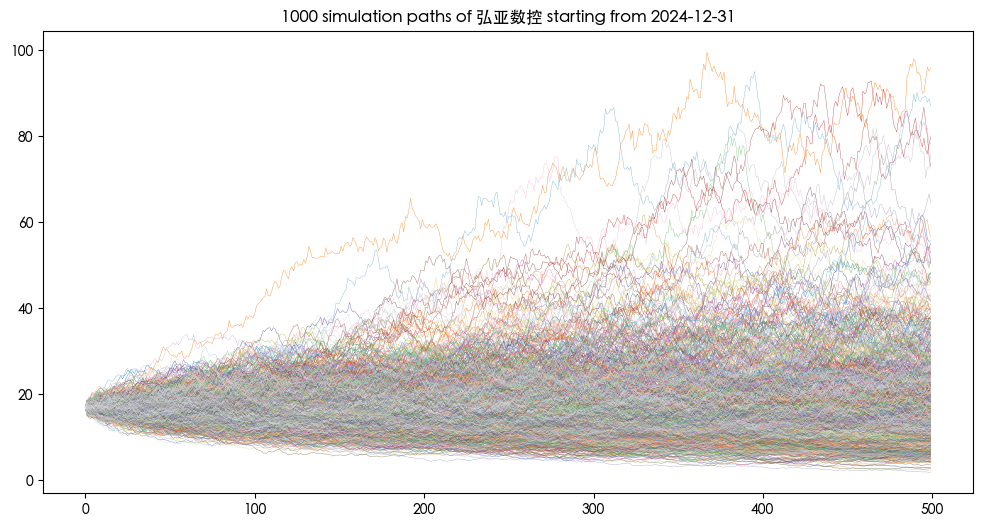

In [22]:
cmaps = [plt.get_cmap('tab20'), plt.get_cmap('tab20b'), plt.get_cmap('tab20c')]
colors = []
for cmap in cmaps:
    colors.extend([cmap(i) for i in np.linspace(0, 1, stockvalue.shape[0] // len(cmaps) + 1)])
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams["axes.unicode_minus"] = False
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(stockvalue.shape[0]):
    path = stockvalue[i, :]
    color = colors[i]
    ax.plot(path, color=color, lw=0.25)
plt.title('1000 simulation paths of 弘亚数控 starting from 2024-12-31')
plt.show()


### Situation and Decision
We price the bonds based on the assumption below:
1. the closing price of the stock has been higher than a certain specific percentage (such as 70%) of the conversion price for 15 days with in 30 consecutive trading days: conversion
2. the closing price of the stock has been lower than a certain specific percentage (such as 70%) of the conversion price for 30 consecutive trading days: $P(\text{downward adjustment}) = 0.6, P(\text{putback}) = 0.4$
3. if neither of the situation occur, we choose the larger one between conversion value and redemption value
   
After get future values of all the simulation path, we discount them to the date of pricing, and calculate the mean of all present values.


#### single bond & single date

In [23]:
# pricing a single convertible bond on a single date with Monte Carlo simulation
def mc_pricing(bond_name, bonds_infos:pd.DataFrame, bonds_trading_data: pd.DataFrame, yield_curves:pd.DataFrame, stock_prices_all:pd.DataFrame, conversion_prices:pd.DataFrame, date, simulations):
    # get basic information of the bond
    bond_infos = bonds_infos[bonds_infos['symbol'] == bond_name]
    bond_code = bond_infos['bond_code'].iloc[0]
    stock_code = bond_infos['stock_code'].iloc[0]
    maturity_date = bond_infos['maturity_date'].iloc[0]
    conversion_start_date = bond_infos['conversion_start_date'].iloc[0]
    conversion_end_date = bond_infos['conversion_end_date'].iloc[0]
    coupon = bond_infos['coupon'].iloc[0] 
    value_date = bond_infos['value_date'].iloc[0]
    
    # get the real price of the bond
    real_prices = bonds_trading_data[bonds_trading_data['bond_code'] == bond_code]
    real_prices = real_prices[real_prices.date >= value_date]
    real_price = real_prices[real_prices.date == date]
    real_price = float(real_price.iloc[-1].close)
    
    # redemption parameters
    redemption_time_period = 30
    redemption_count_period = 15
    redemption_percent = 1.3
    redemption_price = bond_infos['redemption_price'].iloc[0]  # some missing values

    # putback parameters
    put_percent = 0.7
    put_price = 100
    
    # get the number of trading days till maturity(steps of simulation)
    n_1 = days_to_conversion(conversion_end_date, date)
    
    # get the start date of conversion
    n_2 = days_to_conversion(conversion_start_date, date)
    put_start = n_2 + 30
    
    # parameters of simulation
    remaining_days, r= risk_free_rate(date, maturity_date, yield_curves)  # r = rf
    S, v = stock_param(stock_code, stock_prices_all, date)
    AT = 1 / 252
    
    # simulate the stock prices
    stockvalue = S * np.exp(np.cumsum((r - 0.5 * v ** 2) * AT +
                            v * math.sqrt(AT) *
                            np.random.standard_normal((n_1, simulations)), axis=0))
    stockvalue[0] = S
    stockvalue = stockvalue.T
    
    conversion_start = n_2 + 30 if n_2 > 0 else 30
    
    # calculate the payoff of each path based on the condition of clause (redemption, putback, and downward revision)
    strike_ = strike_price(date, conversion_prices, bond_code)
    conversion_ratio_ = 100 / strike_
    payoff = np.zeros((simulations, n_1))
    for i in range(simulations):
        # the strike may change when downward revision occurred in previous path, so reset at the beginning of simulation
        strike = strike_
        conversion_ratio = conversion_ratio_
        for j in range(conversion_start, n_1):
            select = stockvalue[i, j - redemption_time_period:j]  # select 30 consecutive days
            redemption_check = select[np.where(select > strike * redemption_percent)]   
            if np.sum(select > strike * redemption_percent) >= redemption_count_period:  # check if redeem
                payoff[i, j] = np.mean(redemption_check) * conversion_ratio  # conversion
                payoff[i, n_1 - 1] = payoff[i, j] * np.exp(r * (n_1 - 1 - j) / 252)  # future value
                break
            elif j > put_start:
                if np.sum(select < strike * put_percent) == 30:  # check if putback
                    prob = random.uniform(0, 1)
                    if prob >= 0.6:
                        payoff[i, j] = put_price  # putback
                        payoff[i, n_1 - 1] = payoff[i, j] * np.exp(r * (n_1 - 1 - j) / 252)
                        break
                    else:
                        strike = min(strike, np.mean(stockvalue[i, j - 20: j]) * 1.1)  # downward revision with p=0.6
                        conversion_ratio = 100 / strike
    
    # if neither redemption clause nor put clause is triggered, we compare the conversion value of the last date with the redemption price
    payoff = payoff.T
    payoff[-1, payoff[-1, :] == 0] = np.clip(stockvalue.T[-1, payoff[-1, :] == 0] * conversion_ratio_ + max(remaining_days/365, 1) * coupon, a_min = redemption_price, a_max = np.inf)
    
    # discount the payoffs and calculate the model price
    pv = np.mean(payoff.T[:, n_1 - 1]) * np.exp(-1 * r * n_1 / 252)
    price = {'mc_price': pv, 'real_price': real_price, 'date': date}
    return price

In [24]:
# example: 北方转债
price = mc_pricing('北方转债', bonds_infos, bonds_trading_data, yield_curves, stock_prices_all, conversion_prices, '2024-12-31', 10000)  # 10000 simulations

In [25]:
print(price)

{'mc_price': 130.04126516880646, 'real_price': 136.766, 'date': '2024-12-31'}


#### single bond & a series of date

In [26]:
# pricing a single convertible bond on a series of dates with Monte Carlo simulation
def mc_pricing_series(bond_name, bonds_infos:pd.DataFrame, bonds_trading_data:pd.DataFrame, yield_curves:pd.DataFrame, stock_prices_all:pd.DataFrame, conversion_prices:pd.DataFrame, simulations):
    bond_infos = bonds_infos[bonds_infos['symbol'] == bond_name]
    bond_code = bond_infos['bond_code'].iloc[0]
    stock_code = bond_infos['stock_code'].iloc[0]
    maturity_date = bond_infos['maturity_date'].iloc[0]
    conversion_start_date = bond_infos['conversion_start_date'].iloc[0]
    conversion_end_date = bond_infos['conversion_end_date'].iloc[0]
    coupon = bond_infos['coupon'].iloc[0] 
    value_date = bond_infos['value_date'].iloc[0]
    
    real_prices = bonds_trading_data[bonds_trading_data['bond_code'] == bond_code]
    real_prices = real_prices[real_prices.date >= value_date]
    
    # redemption parameters
    redemption_time_period = 30
    redemption_count_period = 15
    redemption_percent = 1.3
    redemption_price = bond_infos['redemption_price'].iloc[0]  # some missing values
    
    # putback parameters
    put_percent = 0.7
    put_price = 100
    
    # get series of date
    date_price = real_prices[['close', 'date']]
    date_price = date_price[date_price['date'] >= '2021-01-20']  # due to limit of data of stock prices 
    length = date_price.shape[0]
    print(f'共计需要计算{length}日的价格')
    price_series = []
    progeress_bar = tqdm(total=length, colour='green', position=0 ,leave=True)
    for i in range(length):
        date = date_price.iloc[i]['date']
        # print(date)
        real_price = date_price.iloc[i]['close']
        # print(real_price)
        # get the number of trading days till maturity(steps of simulation)
        # if the convertible bond matures, n_1 will be 0 for the last day and the stock_value array will be empty
        n_1 = days_to_conversion(conversion_end_date, date)
        # get the start date of conversion
        n_2 = days_to_conversion(conversion_start_date, date)
        put_start = n_2 + 30
        # parameters of simulation
        remaining_days, r= risk_free_rate(date, maturity_date, yield_curves)  # r = rf
        S, v = stock_param(stock_code, stock_prices_all, date)
        AT = 1 / 252
        # simulate the stock prices
        stockvalue = S * np.exp(np.cumsum((r - 0.5 * v ** 2) * AT +
                                v * math.sqrt(AT) *
                                np.random.standard_normal((n_1, simulations)), axis=0))
        stockvalue[0] = S
        stockvalue = stockvalue.T
        conversion_start = n_2 + 30 if n_2 > 0 else 30
        # calculate the payoff of each path based on the condition of clause (redemption, putback, and downward revision)
        strike_ = strike_price(date, conversion_prices, bond_code)
        conversion_ratio_ = 100 / strike_
        payoff = np.zeros((simulations, n_1))
        for i in range(simulations):
            # the strike may change when downward revision occurred in previous path
            # needed to be reset
            strike = strike_
            conversion_ratio = conversion_ratio_
            for j in range(conversion_start, n_1):
                select = stockvalue[i, j - redemption_time_period:j]
                redemption_check = select[np.where(select > strike * redemption_percent)]
        
                if np.sum(select > strike * redemption_percent) >= redemption_count_period:
                    payoff[i, j] = np.mean(redemption_check) * conversion_ratio # * conversion
                    payoff[i, n_1 - 1] = payoff[i, j] * np.exp(r * (n_1 - 1 - j) / 252)
                    break
        
                elif j > put_start:
                    if np.sum(select < strike * put_percent) == 30:
                        prob = random.uniform(0, 1)
                        if prob >= 0.6:
                            payoff[i, j] = put_price  # putback
                            payoff[i, n_1 - 1] = payoff[i, j] * np.exp(r * (n_1 - 1 - j) / 252)
                            break
                        else:
                            strike = min(strike, np.mean(stockvalue[i, j - 20: j]) * 1.1)  # downward revision with p=0.6
                            conversion_ratio = 100 / strike
        
        # if neither redemption clause nor put clause is triggered, we compare the conversion value of the last date with the redemption price
        payoff = payoff.T
        payoff[-1, payoff[-1, :] == 0] = np.clip(stockvalue.T[-1, payoff[-1, :] == 0] * conversion_ratio_ + max(remaining_days/365, 1) * coupon, a_min = redemption_price, a_max = np.inf)
        
        # discount the payoffs and calculate the model price
        pv = np.mean(payoff.T[:, n_1 - 1]) * np.exp(-1 * r * n_1 / 252)
        # print(pv)
        price = {'mc_price': pv, 'real_price': real_price, 'date': date}
        price_series.append(price)
        progeress_bar.update(1)
    progeress_bar.close()

    # save results
    prices_df = pd.DataFrame(price_series)
    if not prices_df.empty:
        table = pa.Table.from_pandas(prices_df)
        pq.write_table(table, f'results/{bond_name}.parquet')

    return prices_df

## Results
- Using the above function, we simulate 1000 times to get the model pricing results.
- The following shows figures of model pricing versus real pricing for several convertible bonds, and it can be observed that for most of the convertible bonds, the trends of the two are very close to each other.

In [28]:
hszz_df = mc_pricing_series('华森转债', bonds_infos, bonds_trading_data, yield_curves, stock_prices_all, conversion_prices, 1000)  # set the number of simulations
hszz_df.head()

共计需要计算459日的价格


100%|██████████| 459/459 [17:44<00:00,  2.32s/it]


,mc_price,real_price,date
0,108.217571,95.560,2021-01-20
1,109.509102,95.651,2021-01-21
2,107.877945,95.211,2021-01-22
3,109.189620,94.649,2021-01-25
4,108.598686,94.200,2021-01-26


In [29]:
hyzz_output = mc_pricing_series('弘亚转债', bonds_infos, bonds_trading_data, yield_curves, stock_prices_all, conversion_prices, 1000)  # set the number of simulations

共计需要计算835日的价格


100%|██████████| 835/835 [28:55<00:00,  2.08s/it]


### Visualization
With date on the x-axis, comparing the modeled price and the real price of a convertible bond.

In [30]:
# draw the figure of model and real price
def fig_model_real_price(bond_name:str):
    bond_df = pd.read_parquet(f'results/{bond_name}.parquet')

    fig2, ax2 = plt.subplots(figsize=(12, 6))
    plt.style.use('ggplot')

    x = pd.to_datetime(bond_df['date'])
    y1 = bond_df['mc_price']
    y2 = bond_df['real_price']

    ax2.plot(x, y1, 'b', label='Model_Price', linewidth=0.5)
    ax2.plot(x, y2, 'r', label='Real_Price', linewidth=0.5)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax2.legend()
    plt.tight_layout()

    plt.show()

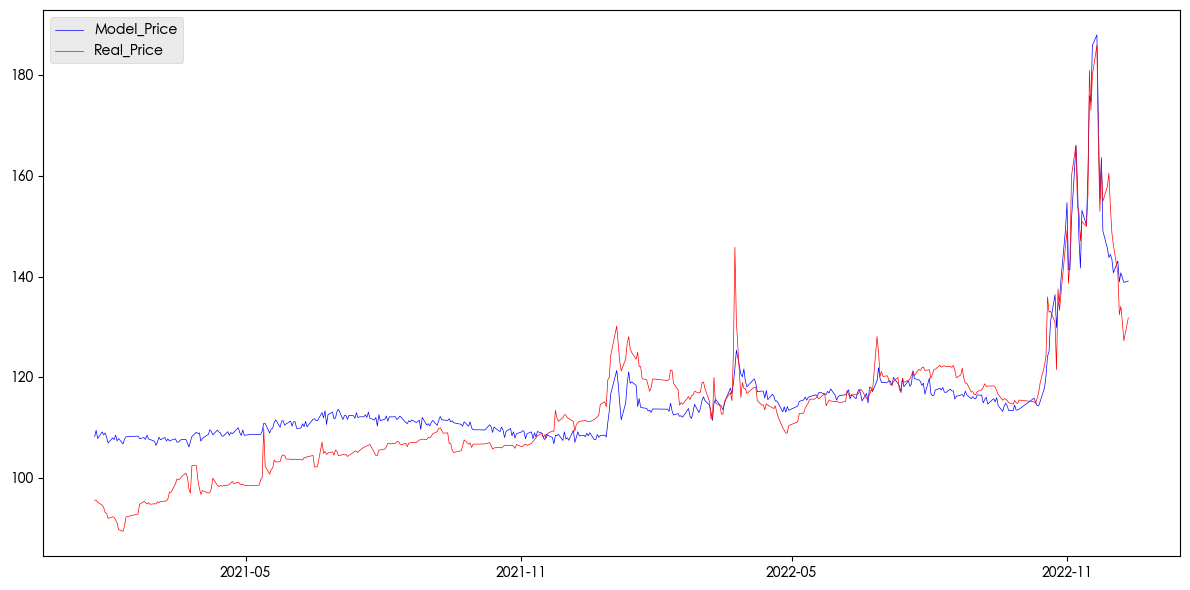

In [31]:
fig_model_real_price('华森转债')

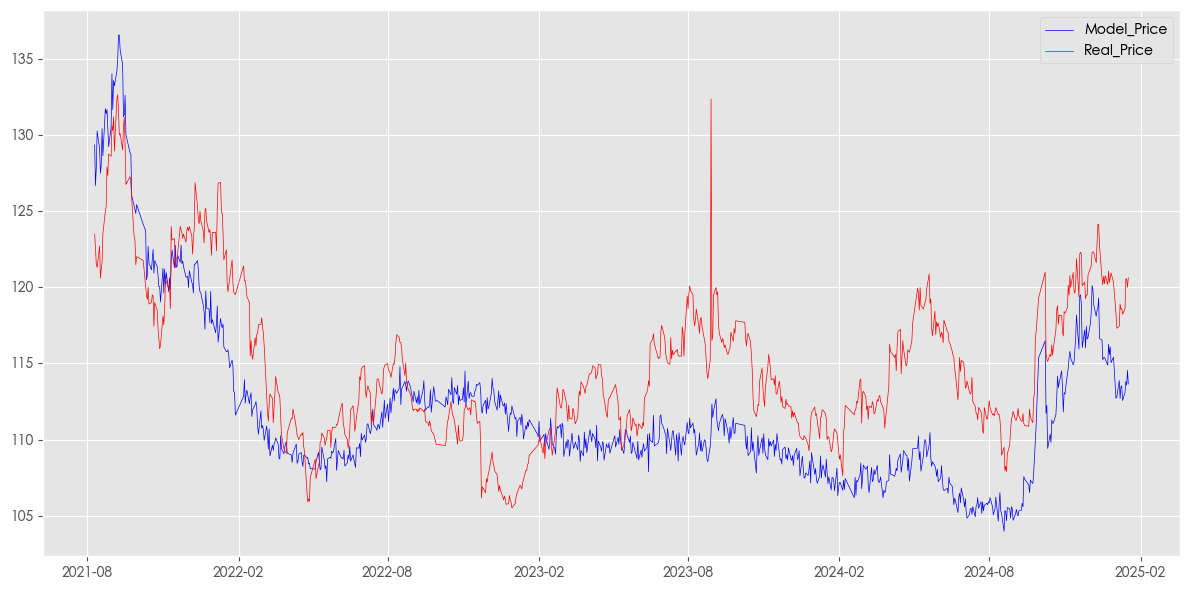

In [32]:
fig_model_real_price('弘亚转债')

Similarly, we graph the results for several other convertible bonds that were previously obtained by applying the above function

南银转债


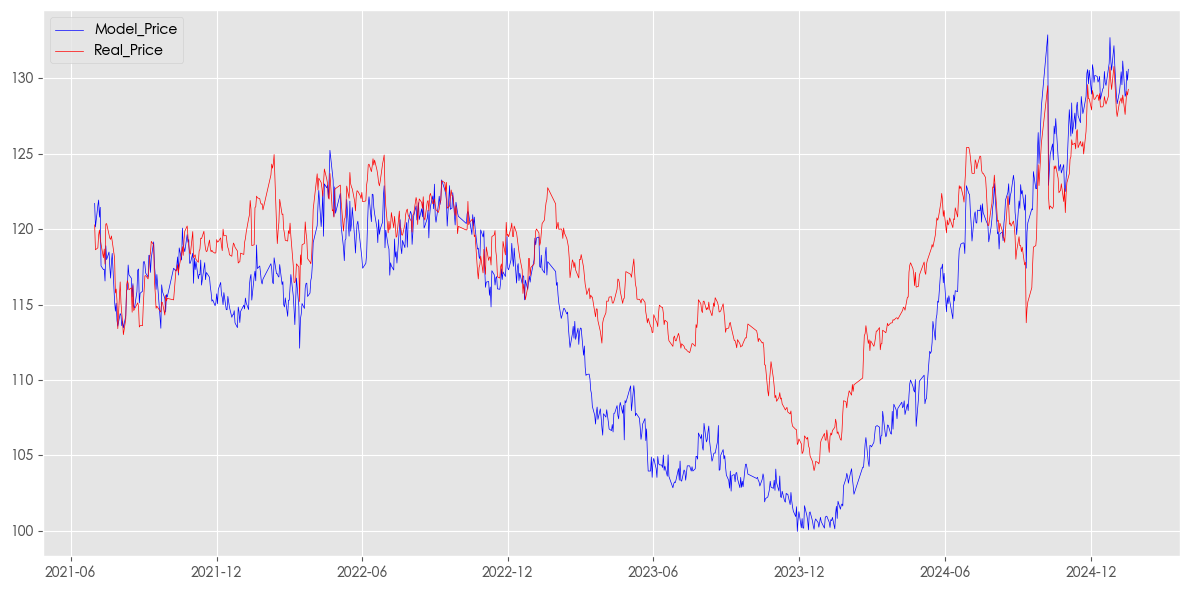

中能转债


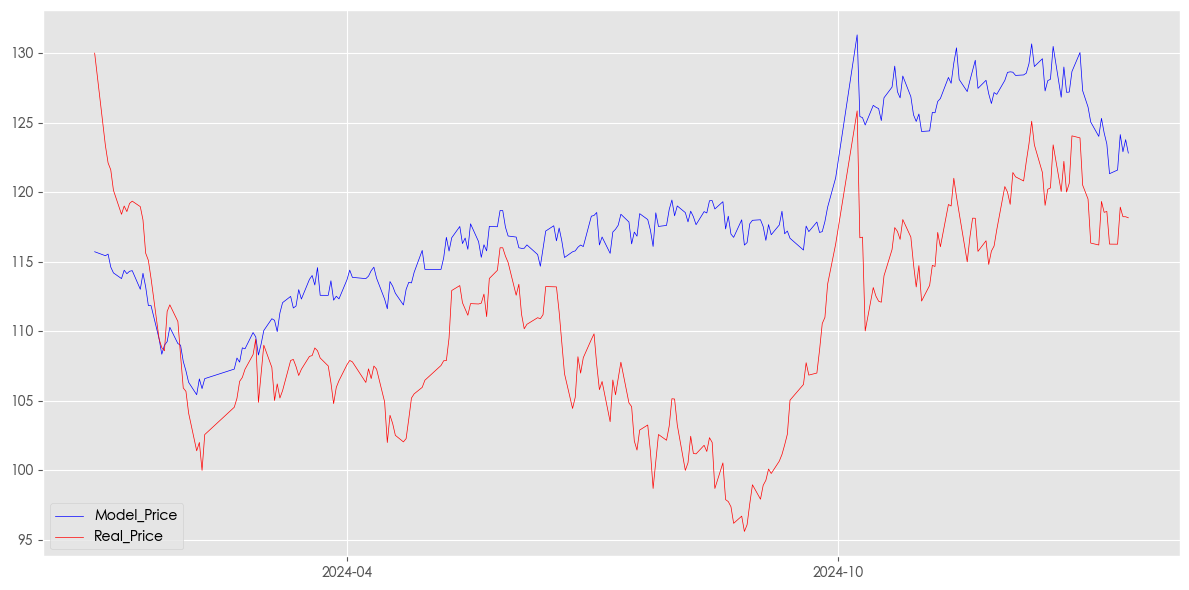

蒙电转债


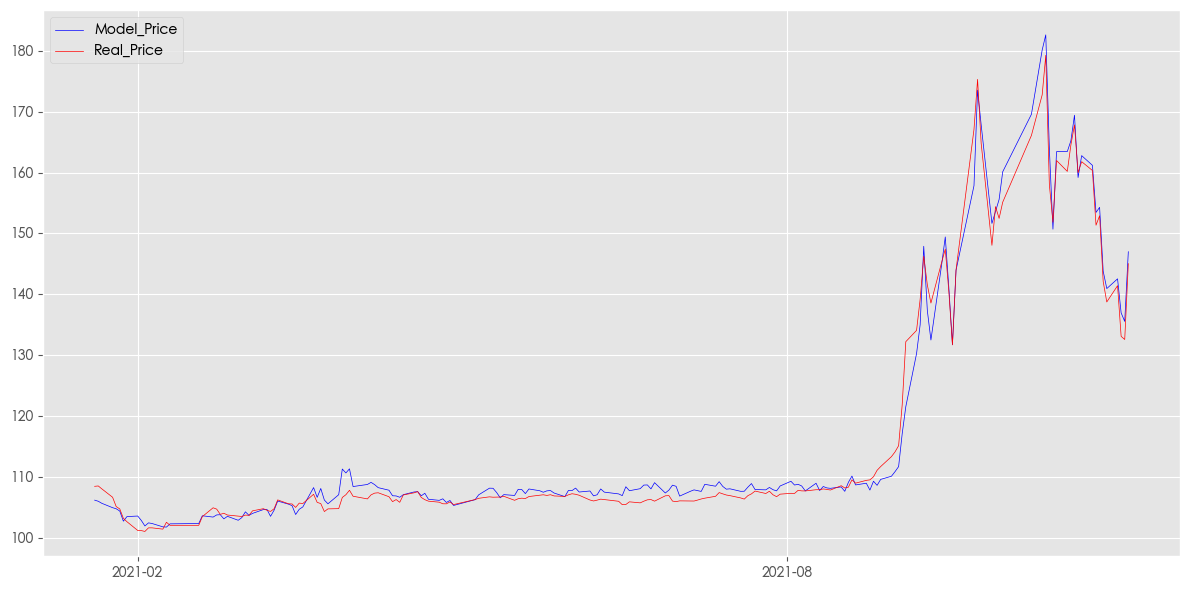

亚泰转债


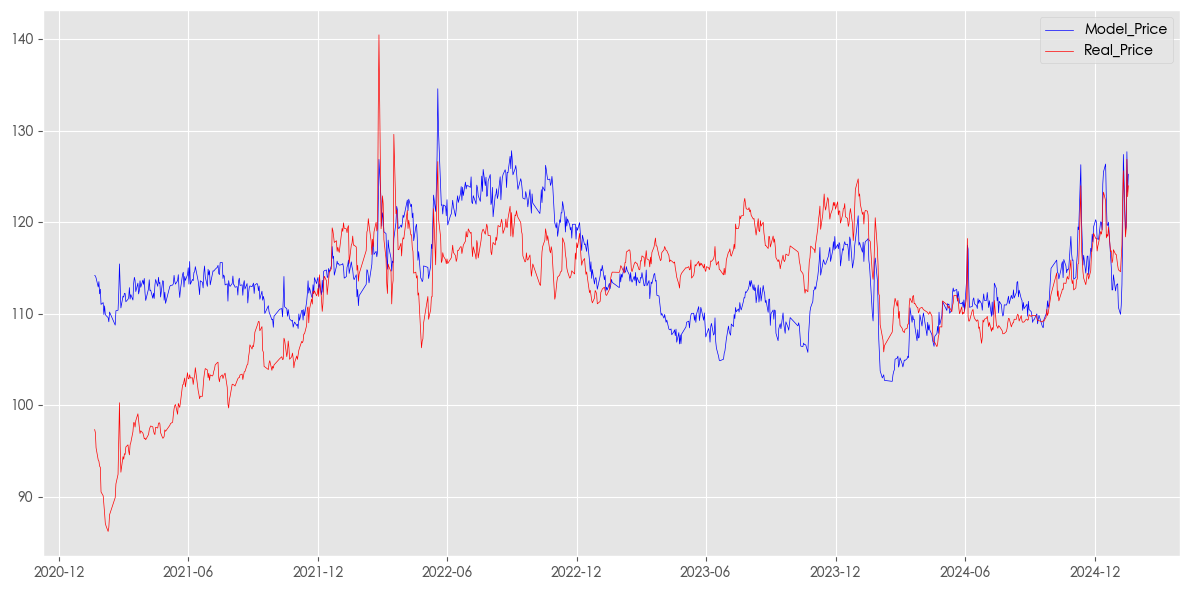

烽火转债


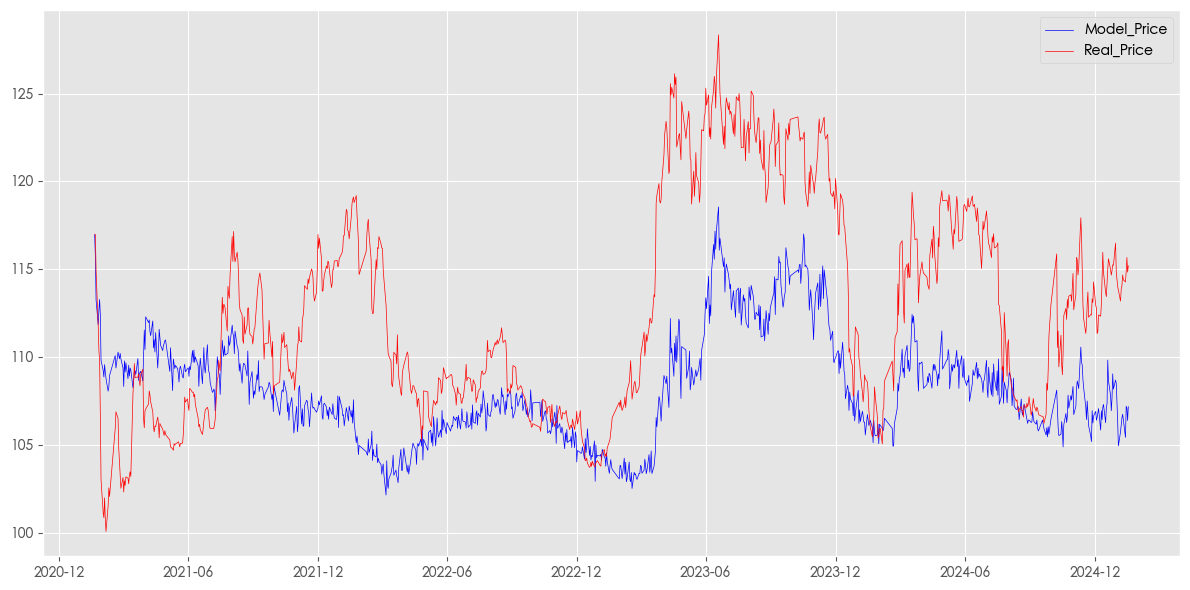

国祯转债


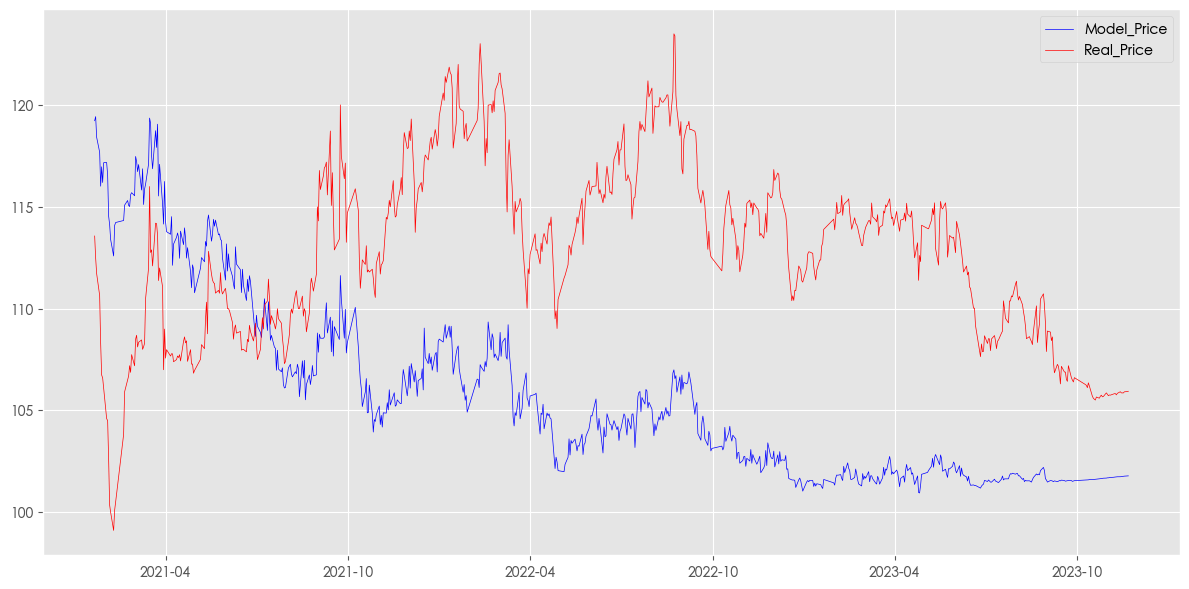

华钰转债


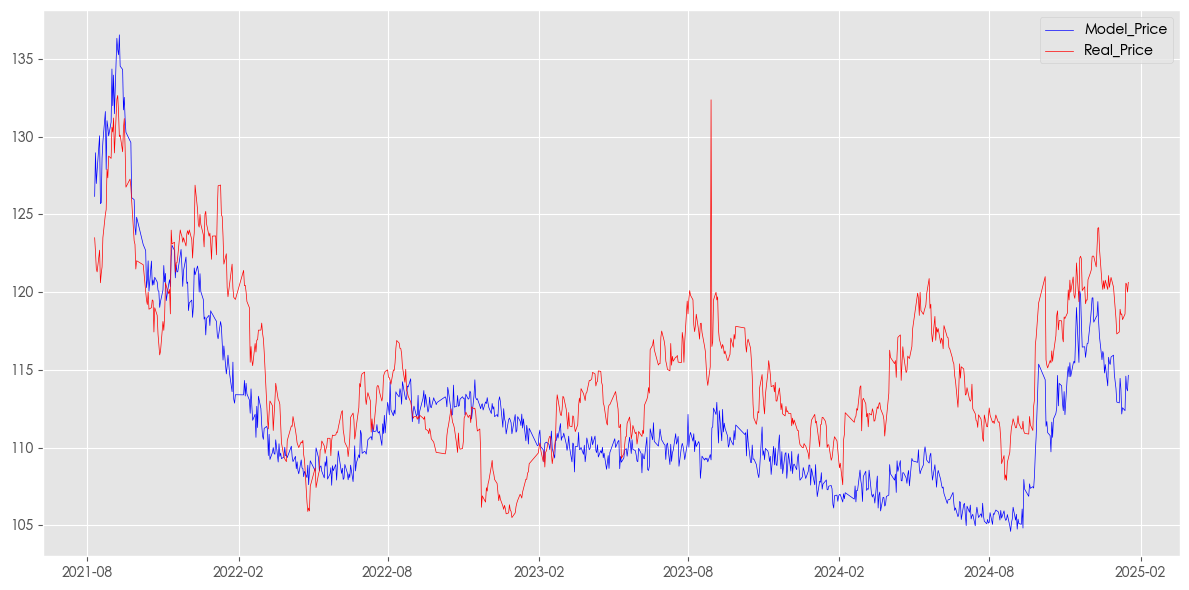

中信转债


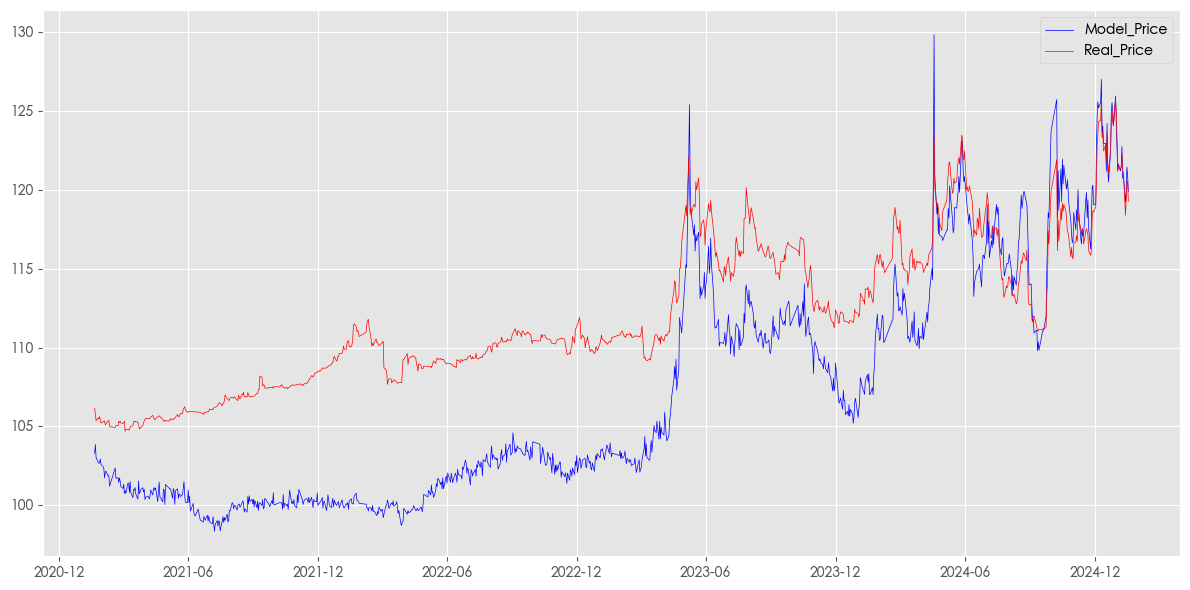

In [35]:
# Get all file names
folder_path = 'results'
file_list = os.listdir(folder_path)
filter_name = ['华森转债', '弘亚转债']  # The name of the bond that has been charted above

for file_name in file_list:
    bond_name_results = os.path.splitext(file_name)[0]  # Get the bond name corresponding to the file
    # Filter out files that have already been drawn
    if bond_name_results not in filter_name:
        print(bond_name_results)
        fig_model_real_price(bond_name_results)

From the graphs above, we can find that:
1. For most convertible bonds, the price from model co-move with real price. Our model is valid to some extent.
2. Real prices are always more volatile, which may caused by irrational investment behaviours. 
3. For some bonds, the price from model are not close to real price. Our model does not capture all factors of valuation of convertible bonds. We talk about this in detail in the **Limitation** part below

## Limitation

The valuation above is a simple valuation based on Monte Carlo simulation and some simple assumptions. Actually, valuation of convertible bonds is very complex and more than what we have done in our project. Here are some limitation of our method and how can we improve it.
1. the simulation of stock price movement is simple and can't capture the real movement.  
Stock returns typically exhibit characteristics such as leptokurtosis, fat tails, volatility clustering, and asymmetry. To describe these characteristics of stock returns and volatility, numerous scholars have proposed a variety of alternative models. Among them, the most widely used ones are the GARCH-M model and the Heston continuous-time stochastic volatility model. 
2. the decisions of investors and companies in different situation are very complex and our assumptions are too naive.  
First, downward adjustment or putback should not be determined randomly. Some researches suggested that we can use machine learning to predict whether to adjust downward or putback. Secondly, when to convert is a hard decision at all times. A classical method is LSM method, i.e. the least square Monte Carlo method, using regression to justify whether hold or convert. 
3. The default risk of the bond also has significant impact on the price of bond.  
Convertible bonds are partially bonds and their prices are affected by default risk. The risk premiums should be considered in a more precise and more complex model.

Time is limited, and we have to stop here with a simple version. Although what we have done is relatively simple, it still cost us large amount of time to collect data, process data, learn the knowledge of convertible bond and method of valuation, write and improve our code. 